<h3 style = 'color:purple' align= 'center'> Import necessary Libraries </h3>

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt

In [2]:
#Setting device to Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<h3 style = 'color:purple' align= 'center'> Importing Data </h3>

In [3]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape

(50000, 2)

In [5]:
#checking class imbalance
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Converting target to numeric variable

In [6]:
df.sentiment = df.sentiment.map({'positive':1,'negative':0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Splitting into Train and Test

In [7]:
X = df.review
y= df.sentiment
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

### Tokenize input text (input_ids,attention_mask)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #Using Bert Tokenizer

In [9]:
def tokenize(text,labels):
    tokens = tokenizer(text,padding= True,truncation= True,return_tensors= 'pt')  #Generates Token Id
    return tokens['input_ids'], tokens['attention_mask'], torch.tensor(labels,dtype = torch.float32)

In [10]:
train_input_ids,train_attention_mask,train_labels = tokenize(X_train.tolist(),y_train.tolist())
test_input_ids,test_attention_mask,test_labels = tokenize(X_train.tolist(),y_train.tolist())

In [11]:
# Creating Training and Test Dataset
train_dataset = TensorDataset(train_input_ids,train_attention_mask,train_labels)
test_dataset = TensorDataset(test_input_ids,test_attention_mask,test_labels)

In [12]:
#Creating train loader and test loader with batch size of 64
train_loader = DataLoader(train_dataset,batch_size =64,shuffle =True)
test_loader = DataLoader(test_dataset,batch_size = 64,shuffle =True)

### Implementing Sentiment Classifier

In [13]:
class SentimentClassifier(nn.Module): 
    def __init__(self):
        super().__init__() #Inheritting from Module Class
        self.bert = BertModel.from_pretrained('bert-base-uncased') #Bert Model to generate contextual embedding

        for param in self.bert.parameters():
            param.requires_grad = False  #Freezing parameters of bert model

        self.classifier = nn.Sequential(   #Implementing a seperate fnn classifier
            nn.Linear(self.bert.config.hidden_size,256), # Bert produces embeddings of size hidden_size
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self,input_ids,attention_mask):
        bert_output = self.bert(input_ids = input_ids,attention_mask = attention_mask) #Passing input id and attention mask to bert model
        sentence_embedding = bert_output.last_hidden_state[:,0,:] # Accesing CLS (semantic meaning of entire sentence)
        return self.classifier(sentence_embedding) #Passing CLS to classifier

In [14]:
model = SentimentClassifier().to(device)  #Instantiating model 
criterion = nn.BCELoss().to(device)  #Loss Function
optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()),lr = 0.001) #Optimizer for finding gradients

In [ ]:
def train_validate(model,criterion ,optimizer, num_epochs = 2):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch, (input_ids, attention_mask,labels) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()     #Zero to previous grads.
            outputs = model(input_ids,attention_mask).squeeze() 
            loss = criterion(outputs,labels)  #Calculating Loss
            loss.backward()  
            train_loss += loss.item()
            optimizer.step()   #Updation
            if (batch+1)%100 == 0:
                print(f"Batch: {batch+1} Epoch: {epoch+1} Loss: {loss.item():.2f}")

        print(f"Total Loss {epoch+1}/{num_epochs} Average Train Loss: {train_loss/len(train_loader):.4f}")

        model.eval() #Evaluation Process
        correct = 0
        total = 0
        all_labels = []
        all_pred = []
        total_val_loss = 0.0
        with torch.no_grad():
            for input_ids,attention_mask,labels in test_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device, dtype = torch.float)
                
                total+= labels.size(0)  #Total Labels each batch
                outputs = model(input_ids,attention_mask).squeeze()
                loss = criterion(outputs,labels)
                total_val_loss+= loss.item()  #validation loss
                
                preds = (outputs>0.5).float()
                all_pred.extend(preds.cpu().numpy())
                correct+= (preds== labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                
            print(f"Epoch {epoch+1} Validation Loss: {total_val_loss/len(test_loader):.4f}")
            print(f"**Validation Accuracy** {100*correct/total:.2f}%")    

    return all_labels, all_pred

In [17]:
all_labels, all_pred = train_validate(model,criterion,optimizer,num_epochs= 2)

Batch: 100 Epoch: 1 Loss: 0.33
Batch: 200 Epoch: 1 Loss: 0.33
Batch: 300 Epoch: 1 Loss: 0.28
Batch: 400 Epoch: 1 Loss: 0.37
Batch: 500 Epoch: 1 Loss: 0.36
Total Loss 1/2 Average Train Loss: 0.3821
Epoch 1 Validation Loss: 0.3265
**Validation Accuracy** 85.81%
Batch: 100 Epoch: 2 Loss: 0.51
Batch: 200 Epoch: 2 Loss: 0.43
Batch: 300 Epoch: 2 Loss: 0.37
Batch: 400 Epoch: 2 Loss: 0.29
Batch: 500 Epoch: 2 Loss: 0.36
Total Loss 2/2 Average Train Loss: 0.3616
Epoch 2 Validation Loss: 0.3427
**Validation Accuracy** 84.83%


<h3 align = 'center' style ='color:purple'> Model Evaluation </h3>

In [21]:
report = classification_report(all_labels,all_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84     17589
         1.0       0.80      0.93      0.86     17411

    accuracy                           0.85     35000
   macro avg       0.86      0.85      0.85     35000
weighted avg       0.86      0.85      0.85     35000



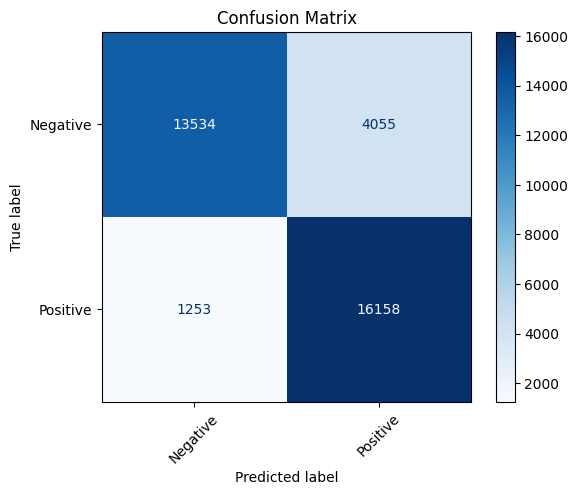

In [25]:
cm = confusion_matrix(all_labels,all_pred)
disp = ConfusionMatrixDisplay(cm,display_labels = ["Negative","Positive"])
disp.plot(cmap = plt.cm.Blues, xticks_rotation = 45)
plt.title('Confusion Matrix')
plt.show()

### Saving Model

In [26]:
torch.save(model.state_dict(),'sentiment_model.pth') 